# Human in the loop

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o')
small_llm = ChatOpenAI(model = 'gpt-4o-mini')

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [6]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()


In [7]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x130d696a0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x130d696a0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x130d696a0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x130d696a0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x130d696a0>)]

In [8]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [9]:
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 최초 생성시
embedding_function = OpenAIEmbeddings(model = 'text-embedding-3-large')
vector_store = Chroma(
    embedding_function= embedding_function,
    collection_name= 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs = {'k':3})


# 생성된 retriever 참조시

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

In [10]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [11]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [12]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    """
    주어진 `state`에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (AgentState): 메시지 기록과 요약을 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 메시지와 요약을 state에서 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약이 비어있지 않으면, 요약을 메시지 앞에 추가합니다.
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    
    # LLM과 도구를 사용하여 메시지에 대한 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': [response]}

In [13]:
from typing import Literal
from langgraph.types import interrupt, Command

def human_review(state: AgentState) -> Command[Literal['tools']]:
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({
        'question': '이렇게 진행하면 될까요?',
        'tool_call': tool_call
    })
    review_action = human_review['action']
    review_data = human_review.get('data',None)    

    if review_action =='continue':
        return Command(goto='tools')
    
    if review_action == 'update_args':
        # 도구를 더 효율적으로 사용하기 위해 AIMessage의 `tool_calls` 필드를 업데이트
        updated_ai_message = {
            'id': last_message.id,
            'role': 'ai',
            'content': last_message.content,
            'tool_calls': [{
                'id': tool_call['id'],
                'name': tool_call['name'],
                'args': review_data
            }],
        }
        return Command(goto='tools', update={'messages': [updated_ai_message]})
    
    if review_action == 'update_tool':
        # 다른 도구를 사용하기 위해 `ToolMessage`를 업데이트
        updated_tool_message = {
            'tool_call_id': tool_call['id'],
            'name': tool_call['name'],
            'role': 'tool',
            'content': review_data
        }
        return Command(goto='agent', update={'messages': [updated_tool_message]})

In [14]:
def summarize_messages(state: AgentState) -> AgentState:
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    # state에서 메시지와 요약을 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트를 생성합니다.
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트를 생성합니다.
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약을 생성합니다.
    summary = small_llm.invoke(summary_prompt)
    
    # 요약된 메시지를 반환합니다.
    return {'summary': summary.content}

In [15]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState) -> AgentState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 세 개의 메시지를 제외한 나머지 메시지를 삭제합니다.
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    # 삭제된 메시지를 포함하는 새로운 state를 반환합니다.
    return {'messages': delete_messages}

- 영상에는 수정하면서 누락된 부분입니다 (MessagesState -> AgentState)
- `should_continue`는 `summary`를 바라보지 않기 때문에 에러가 발생하지는 않습니다

In [16]:
from typing import Literal

def should_continue(state: AgentState) -> Literal['tools', 'summarize_messages']:
    """
    주어진 state에 따라 다음 단계로 진행할지를 결정합니다.

    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state.

    Returns:
        Literal['tools', 'summarize_messages']: 다음 단계로 'tools' 또는 'summarize_messages'를 반환합니다.
    """
    # state에서 메시지를 가져옵니다.
    messages = state['messages']
    # 마지막 AI 메시지를 확인합니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'human_review'
    
    # 도구 호출이 없으면 'summarize_messages'를 반환합니다.
    return 'summarize_messages'

- `node`를 추가하고 `edge`로 연결합니다

In [17]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(human_review)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [18]:
from langgraph.graph import START, END


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['human_review', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

- 히스토리 관리를 위해 `checkpointer`를 사용합니다
    - `MemorySaver`는 메모리에 저장하는 방법입니다


In [19]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(checkpointer=checkpointer)

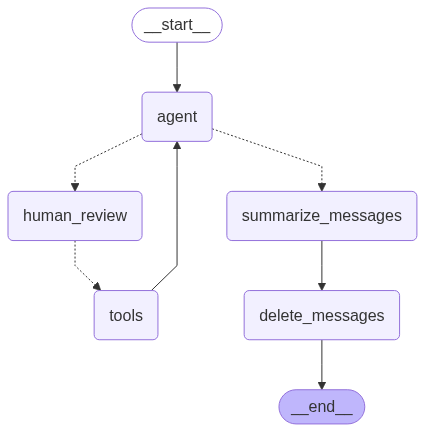

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- `checkpointer`를 사용하는 경우, 관리를 위해 `thread_id`를 사용합니다

In [28]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

query = 'LLM survey 논문의 내용을 요약해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

LLM survey 논문의 내용을 요약해주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_jeLeeZjOtQR8hAkLKiTqmXo7)
 Call ID: call_jeLeeZjOtQR8hAkLKiTqmXo7
  Args:
    query: Large Language Model survey


In [22]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[HumanMessage(content='LLM survey 논문의 내용을 요약해주세요.', additional_kwargs={}, response_metadata={}, id='01fbd6a7-9454-49b3-a3f9-8101ca5db6e7'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QOF4uPH8HliP7pPCfmfCqBLG', 'function': {'arguments': '{"query":"LLM survey"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 746, 'total_tokens': 762, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-82c3a60f-dc45-4ea0-8465-4513bc323b2d-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LLM survey'}, 'id': 'call_QOF4uPH8HliP7pPCfmfCqBLG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 746, 'out

In [23]:
graph.get_state(config).next

('human_review',)

In [24]:
for chunk in graph.stream(
    Command(resume={'action':'update_args', 'data':{'query':'Large Language Model: A Survey'}}),
    config = config,
    stream_mode = 'updates'
):
    print(chunk)

{'human_review': {'messages': [{'id': 'run-82c3a60f-dc45-4ea0-8465-4513bc323b2d-0', 'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_QOF4uPH8HliP7pPCfmfCqBLG', 'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}}]}]}}
{'tools': {'messages': [ToolMessage(content='Published: 2024-12-09\nTitle: Questioning the Survey Responses of Large Language Models\nAuthors: Ricardo Dominguez-Olmedo, Moritz Hardt, Celestine Mendler-Dünner\nSummary: Surveys have recently gained popularity as a tool to study large language\nmodels. By comparing survey responses of models to those of human reference\npopulations, researchers aim to infer the demographics, political opinions, or\nvalues best represented by current language models. In this work, we critically\nexamine this methodology on the basis of the well-established American\nCommunity Survey by the U.S. Census Bureau. Evaluating 43 different language\nmodels using de-facto standard prompting methodologies, we establish two\ndo

In [25]:
graph.get_state(config).values['messages']

[AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-82c3a60f-dc45-4ea0-8465-4513bc323b2d-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}, 'id': 'call_QOF4uPH8HliP7pPCfmfCqBLG', 'type': 'tool_call'}]),
 ToolMessage(content='Published: 2024-12-09\nTitle: Questioning the Survey Responses of Large Language Models\nAuthors: Ricardo Dominguez-Olmedo, Moritz Hardt, Celestine Mendler-Dünner\nSummary: Surveys have recently gained popularity as a tool to study large language\nmodels. By comparing survey responses of models to those of human reference\npopulations, researchers aim to infer the demographics, political opinions, or\nvalues best represented by current language models. In this work, we critically\nexamine this methodology on the basis of the well-established American\nCommunity Survey by the U.S. Census Bureau. Evaluating 43 different language\nmodels using de-facto standard prompting methodologies, we establish two\ndomina

In [29]:
for chunk in graph.stream(
    Command(resume={'action':'update_tool', 'data':"arxiv 말고 web에서 검색해주세요."}),
    config = config,
    stream_mode = 'updates'
):
    print(chunk)

{'human_review': {'messages': [{'tool_call_id': 'call_jeLeeZjOtQR8hAkLKiTqmXo7', 'name': 'arxiv', 'role': 'tool', 'content': 'arxiv 말고 web에서 검색해주세요.'}]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a1ofA1W3eBoCyVkHEhp4bvGg', 'function': {'arguments': '{"query":"Large Language Model survey summary"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2115, 'total_tokens': 2136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2048}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9778d287-2e39-4029-b77e-a5192c01d248-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Large Language Model surve

In [30]:
for chunk in graph.stream(
    Command(resume={'action':'continue'}),
    config = config,
    stream_mode = 'updates'
):
    print(chunk)

{'human_review': None}


/Users/a202304035/llm_agent_practice/.venv/lib/python3.13/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content='2023. 4. 6. ... 특성 · (의도치 않게 발현된) 놀라운 기능들 · LLM은 AI 알고리즘 개발 및 사용 방식을 혁신합니다. · LLM의 개발에는 연구와 엔지니어링의 구분이 명확\xa0... 2024. 2. 9. ... Abstract:Large Language Models (LLMs) have drawn a lot of attention due to their strong performance on a wide range of natural language\xa0... 2024. 4. 17. ... 이 섹션에서는 LLM의 배경에 대한 개요를 제시하고 GPT 시리즈 모델의 기술적 발전을 요약합니다. 2.1. Background for LLMs. 일반적으로 LLM(대형 언어\xa0... 2023. 3. 31. ... Interestingly, when the parameter scale exceeds a certain level, these enlarged language models not only achieve a significant performance\xa0... 2024. 9. 18. ... ✓ Abstract · 여기서는 3가지 가장 인기있는 LLM Families (GPT, LLaMA, PaLM)을 포함하여 가장 눈에 띄는 LLM을 review하고, 그 특징과 기여도, 한계에\xa0...', name='duckduckgo_search', id='fc28d331-1b9f-4ac2-9b33-a17747e87053', tool_call_id='call_a1ofA1W3eBoCyVkHEhp4bvGg')]}}
{'agent': {'messages': [AIMessage(content='여기 LLM(대규모 언어 모델)에 대한 설문 및 리뷰에서 다루어지는 주요 내용입니다:\n\n1. **LLM의 배경**: LLM은 자연어 처리(NLP) 분야에서 강력한 성능을 보이며, 이러

In [31]:
graph.get_state(config).values['messages']

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a1ofA1W3eBoCyVkHEhp4bvGg', 'function': {'arguments': '{"query":"Large Language Model survey summary"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2115, 'total_tokens': 2136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2048}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9778d287-2e39-4029-b77e-a5192c01d248-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Large Language Model survey summary'}, 'id': 'call_a1ofA1W3eBoCyVkHEhp4bvGg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2115, 'output_tokens': 21, 'total_tokens': 2136, 'input_token_details'